In [1]:
# import packages for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os

In [2]:
from src.fasta_utilities import get_TF_fasta
# obtain the TF fasta file

get_TF_fasta(
    'data/master_tf.csv',
    'data/master_tf.fasta'   
) 

# This file is then processed manually on fldpnn2 server and  
# the output file is saved as 'data/fldpnn2_master.txt'

In [4]:
from src import fldpnn2_scores
fldpnn2_master = fldpnn2_scores.get_scores()
fldpnn2_master

,ID,idr_ranges,AA,Disordered,fldpnn2_score
0,B7WN96,"[3-39,55-60,64-74,163-166,196-207,217-239,283-...","[M, E, T, A, N, Y, Y, L, P, S, P, P, Y, S, S, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.233, 0.261, 0.3, 0.352, 0.38, 0.348, 0.399,..."
1,P22980,"[1-27,31-35,58-73,75-79,85-143,227-230,232-324]","[M, N, T, E, T, S, T, Q, S, A, P, S, D, T, Y, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.359, 0.368, 0.366, 0.362, 0.365, 0.382, 0.3..."
2,P28515,"[16-38,89-93,114-118,130-134,138-142,144-152,1...","[M, D, Y, E, G, K, P, V, E, F, T, L, G, T, S, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.206, 0.222, 0.214, 0.241, 0.204, 0.209, 0.1..."
3,Q10655,"[1-6,9-15,18-28,30-38,40-59,187-191,194-201,20...","[M, D, N, N, Y, N, D, N, V, N, G, W, A, E, M, ...","[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0.295, 0.322, 0.351, 0.392, 0.402, 0.332, 0.2..."
4,Q17381,"[1-17,21-44,71-84,97-100,108-111,113-118,160-1...","[M, T, S, P, S, S, D, E, D, I, I, D, I, R, V, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.285, 0.294, 0.365, 0.436, 0.429, 0.369, 0.3..."
5,Q18612,"[1-33,89-103,112-122,135-139,216-221]","[M, V, K, S, T, T, A, G, N, N, A, V, S, S, L, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.424, 0.345, 0.328, 0.426, 0.534, 0.577, 0.5..."


In [7]:
# translation of the uniport id to gene name
protein_inf = [
    ('HLH-1', 'P22980'),
    ('ELT-1', 'P28515'),
    ('ELT-2', 'Q10655'),
    ('ELT-3', 'B7WN96'),
    ('PHA-4', 'Q17381'),
    ('HND-1', 'Q18612'),
]
master_gene_names = {
    uniprot_id: gene for (gene, uniprot_id) in protein_inf
}

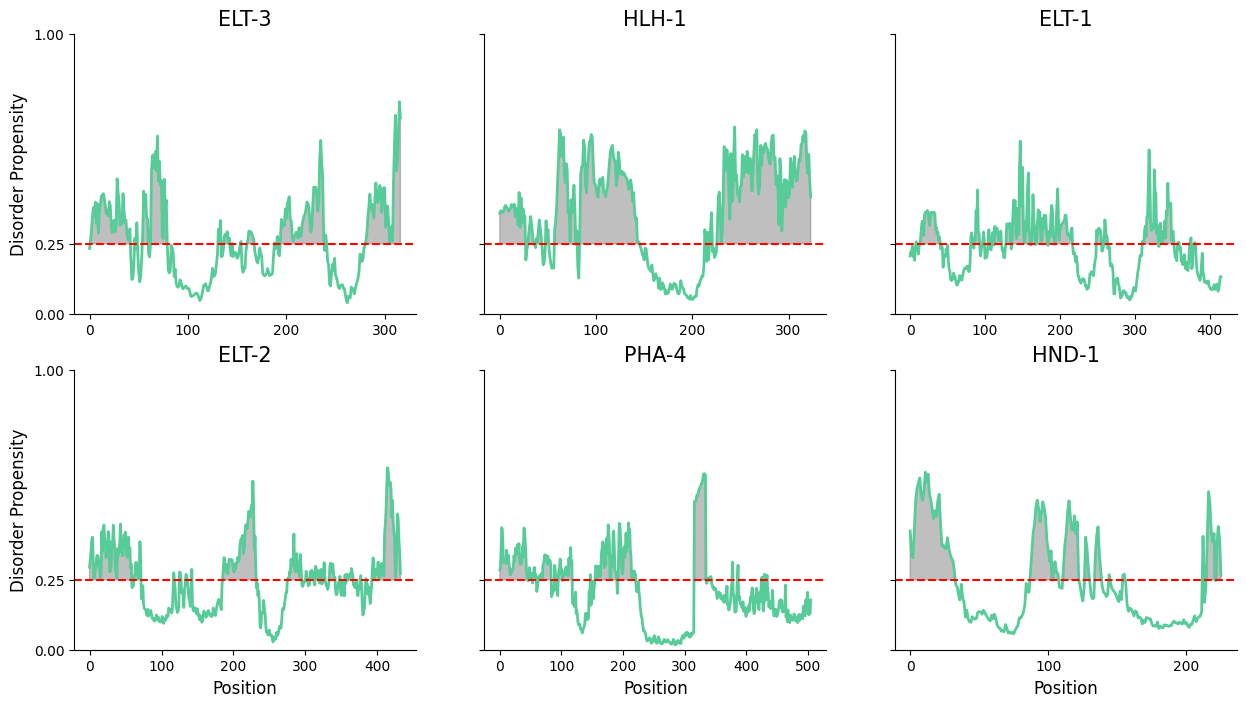

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for axs in axes: 
    axs.spines[['top', 'right']].set_visible(False)

thresh = 0.25

for ax, (i, row) in zip(axes, fldpnn2_master.iterrows()):
    uniprot_id = row['ID']
    name = master_gene_names[uniprot_id]
    x = np.arange(len(row['fldpnn2_score']))
    y = np.array(row['fldpnn2_score'])
    ax.plot(x, y, color='#57cc99', linewidth=2)
    ax.axhline(thresh, color='red', linestyle='--', linewidth=1.5)
    ax.fill_between(x, y, thresh, where=(y > thresh), color='grey', alpha=0.5)
    ax.set_title(name, fontsize=15)
    ax.set_yticks([0, thresh, 1])
    ax.set_ylim(0, 1)
    x_ticks = np.arange(0, len(x)+1, 100)
    ax.set_xticks(x_ticks)
    if i >= 3:ax.set_xlabel('Position', fontsize=12)
    if i == 0 or i == 3: ax.set_ylabel('Disorder Propensity', fontsize=12)
    

# plt.tight_layout()
plt.show()